<a href="https://colab.research.google.com/github/yyqq-git/ai-python-etc/blob/main/HODL_SP24_Lec_03A_Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification on Tabular Data - Predicting Heart Disease





## Introduction

This colab shows how to set up and train a Neural Network model for *binary classification*, when the dataset is *tabular* (rather than unstructured data like images or text) and has a mix of numeric and categorical features. Since tabular datasets are often made available in CSV files, the colab demonstrates the full CSV-to-trained-model workflow.




### The dataset

The dataset ([more background on the data](https://archive.ics.uci.edu/ml/datasets/heart+Disease)) has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not and is the label (i.e., the dependent variable) that we want to predict using the other columns.

Feature description (copied from [here](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)):

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Technical preliminaries

Throughout the course, we will load the following packages as the first step.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

When we train Deep Learning models, randomness enters the process in a few different places.
*   Starting values for the weights (the optimizer will try to improve these weights)
*   The order in which we process the minibatches when we do SGD
*   When we split the data into Train, Validation, Test etc
*   Dropout (if we use regularization)

We next set the seed for the different random number generators so that the
results will be the same every time the notebook is run. 🤞



In [ ]:
keras.utils.set_random_seed(42)

## Read in the data

Conveniently, the dataset in CSV form has been made available online (by [Francois Chollet](https://twitter.com/fchollet)) and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [ ]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [ ]:
df.shape

(303, 14)

The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable):

Let's take a look at the first few rows:

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Let's take a quick look to see if the 1s and 0s are balanced.

In [ ]:
df.target.value_counts(normalize=True, dropna=False)

0    0.726073
1    0.273927
Name: target, dtype: float64

It is a bit imbalanced.

What's a 'naive' **baseline model** for this problem?

<br> <br> <br> <br>

A baseline model would be to just predict a probability of 0.0 for every patient. That will result in 72.6% accuracy.

Any fancy model we build needs to do better than this.

We will come back to this later.

## Preprocessing

This dataset has both categorical variables and numeric variables.

It will be convenient (for later processing) to collect these groups of variables into two lists.

In [ ]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']

NNs require all their inputs to be numeric so we will first preprocess this raw data as follows:
- *one-hot encode* the categorical variables
- *normalize* the numeric variables


With the pandas `get_dummies` function, you can one-hot-encode in one line.


In [ ]:
df = pd.get_dummies(df, columns = categorical_variables)

In [ ]:
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,67,160,286,108,1.5,2,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,67,120,229,129,2.6,2,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,37,130,250,187,3.5,3,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,41,130,204,172,1.4,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0



NNs work best when the inputs are all roughly in the same range. So standard practice is to **standardize** the numeric variables.

Before we do so, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [ ]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(test_df.index)

In [ ]:
train_df.shape

(242, 30)

In [ ]:
test_df.shape

(61, 30)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [ ]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [ ]:
means

age          54.268595
trestbps    131.995868
chol        246.512397
thalach     149.805785
oldpeak       1.032645
slope         1.590909
dtype: float64

Let's standardize the train and test dataframes with these means and standard deviations.

In [ ]:
train_df[numerics]= (train_df[numerics] - means)/sd

In [ ]:
test_df[numerics]= (test_df[numerics] - means)/sd

In [ ]:
train_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,0.963746,0.721939,-0.278690,0.008396,1.083461,2.226814,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,1.405254,1.554681,0.814423,-1.807247,0.399542,0.646494,1,0,1,0,...,1,0,0,0,1,0,0,0,1,0
2,1.405254,-0.665964,-0.361189,-0.899426,1.339930,0.646494,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,-1.906055,-0.110803,0.071931,1.607891,2.109339,2.226814,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,-1.464547,-0.110803,-0.876809,0.959447,0.314052,-0.933825,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0


At this point, the data is entirely numeric.

The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [ ]:
train = train_df.to_numpy()
test = test_df.to_numpy()

Final step: Our features $X$ and dependent variable $y$ are both inside the `train` and `test` arrays so let's separate them out.

Note that the `target` column is our $y$ variable and it is column #6 from the left (counting from 0).

The `np.delete` function is perfect for selecting all columns except one.

In [ ]:
train_X = np.delete(train, 6, axis=1)
test_X = np.delete(test, 6, axis=1)

Check that it worked.

In [ ]:
train_X.shape, test_X.shape

((242, 29), (61, 29))

Next, select just the 6th column and define the train and test $y$ variables.

In [ ]:
train_y = train[:, 6]
test_y = test[:, 6]

In [ ]:
train_y.shape, test_y.shape


((242,), (61,))

## Build a model



### Define model in Keras

Creating an NN  is usually just a few lines of Keras code as we saw in class.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

The following model is what we created in class.

In [ ]:
num_columns = train_X.shape[1]

# define the input layer
input = keras.Input(shape=num_columns)

# feed the input vector to the hidden layer
# optional: you can give names to each layer to help
# keep track. This doesn't affect the training etc.

h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 Hidden (Dense)              (None, 16)                480       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's hand-calculate the number of parameters to verify.

In [ ]:
(29 + 1)* 16 + (16 + 1) * 1

497

We can "visualize" the network graphically as well using Keras' `plot_model` function.

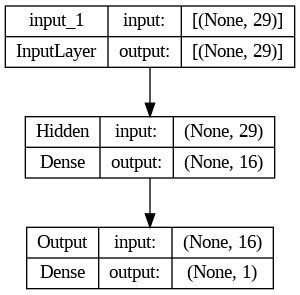

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a sibling of SGD called **Adam** which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.

These three choices can be made using the `model.fit` function.

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size*. We referred to this as a *minibatch* in lecture but in keeping with convention, we will simply refer to it as *batch* from this point on. 32 is a good default for the batch size.
* The number of *epochs* i.e., how many passes through the training data. Usually 20-30 epochs is a good starting point but since this dataset is very small, each epoch will be very quick so let's run it for 300 epochs. It will allow us to see if any overfitting happens
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

OK, let's train the model using the `model.fit` function!

We will store the output of the training process in `history`. It will make it easy later to investigate what happened during training.

In [ ]:
history = model.fit(train_X,              # the array with the input X columns
                    train_y,              # the array with the output y column
                    epochs=300,           # number of epochs to run
                    batch_size=32,        # number of samples (ie data points) per batch
                    verbose=1,            # verbosity during training
                    validation_split=0.2) # use 20% of the data for validation

Epoch 1/300
7/7 [==============================] - 0s 26ms/step - loss: 0.1636 - accuracy: 0.9223 - val_loss: 0.4938 - val_accuracy: 0.8163
Epoch 2/300
7/7 [==============================] - 0s 14ms/step - loss: 0.1633 - accuracy: 0.9223 - val_loss: 0.4947 - val_accuracy: 0.8163
Epoch 3/300
7/7 [==============================] - 0s 13ms/step - loss: 0.1628 - accuracy: 0.9223 - val_loss: 0.4953 - val_accuracy: 0.8163
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9223 - val_loss: 0.4958 - val_accuracy: 0.8163
Epoch 5/300
7/7 [==============================] - 0s 11ms/step - loss: 0.1622 - accuracy: 0.9223 - val_loss: 0.4978 - val_accuracy: 0.8163
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 0.1620 - accuracy: 0.9223 - val_loss: 0.4999 - val_accuracy: 0.8163
Epoch 7/300
7/7 [==============================] - 0s 10ms/step - loss: 0.1624 - accuracy: 0.9275 - val_loss: 0.5014 - val_accuracy: 0.8163
Epoch 8/300
7/7 [=====

Let's take a moment to understand the numbers being reported.


---



Plotting metrics like loss and accuracy as a function of the # of epochs is a good way to understand how training has progressed.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

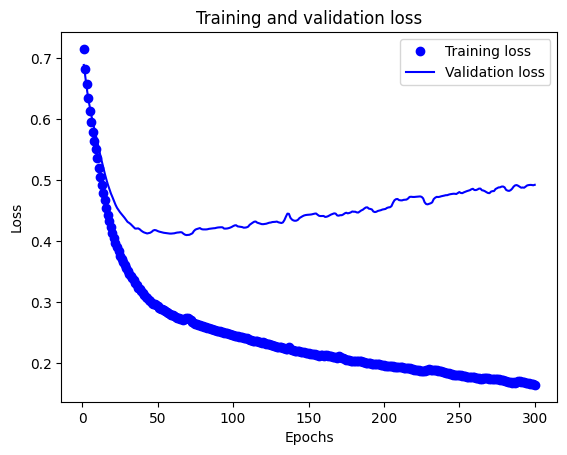

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Do you think there's overfitting?

<br> <br> <br> <br> <br> <br> <br> <br>



There does seem to be overfitting.

If there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would an example of **early stopping**.


Let's look at the accuracy curves as well.



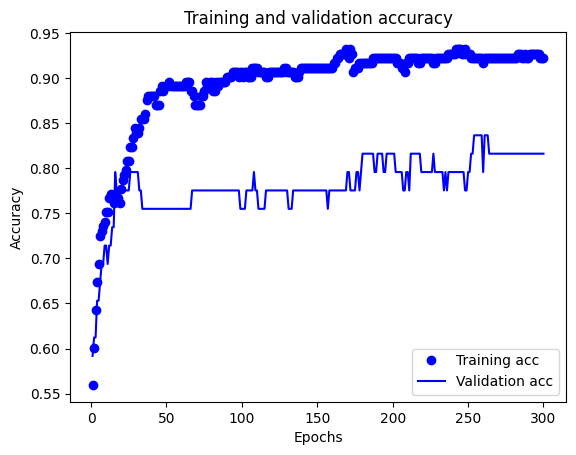

In [ ]:
# https://github.com/fchollet/deep-learning-with-python-notebooks/

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate the model

Let's see **how well the model does on the test set**.

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [ ]:
model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 7ms/step - loss: 0.3866 - accuracy: 0.8361


[0.3865666091442108, 0.8360655903816223]

How does the accuracy of this "neural model" 😀 compare to the accuracy of our baseline model?

The baseline model had an accuracy of 72.6% so our first NN model is certainly beating - phew! 😅


## Predicting new data (i.e., *inference*) with the model

We will see in later colabs how to save a Keras model and use it for prediction later.  But we want to point out that the simple approach we followed in this colab has a key shortcoming.

We did the pre-processing - the one-hot encoding and normalization - *outside* the model. This means that we have to remember what pre-processing we did and carry that information (e.g., the mean and variance of each variable) along with the model to correctly use the model in the future.

A very elegant way to avoid this issue is to use [Keras preprocessing layers](https://keras.io/guides/preprocessing_layers/). In the interest of time, we aren't covering it in this colab but we encourage you to check out this [colab](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/structured_data/ipynb/structured_data_classification_from_scratch.ipynb) which shows how to solve our exact heart-disease prediction problem above using preprocessing layers.
